In [1]:
from scipy.signal import find_peaks
from astropy.io import fits
from specutils import Spectrum1D
import matplotlib.pyplot as plt
import numpy as np
from astropy import units as u
import requests
from io import BytesIO
import os
import csv


## Inject Laser

In [2]:
def inject_and_plot_laser(obj_id, filt, folder="/datax/scratch/emmay/galah_spectra",
                          fwhm=1.5, laser_amp_percent=20, plot=True):
    """
    Injects a Gaussian laser spike into GALAH FITS spectrum and plots it.

    Parameters:
        obj_id (str): Object ID
        filt (str): Filter (e.g. 'B', 'V', 'R', 'I')
        folder (str): Path to FITS files
        fwhm (float): FWHM of the Gaussian in pixels
        laser_amp_percent (float): Amplitude of injection as percentage of max flux
        plot (bool): Whether to show the plot

    Returns:
        wavelength (np.ndarray): Wavelength array (in Å)
        flux_injected (np.ndarray): Flux array with injected Gaussian
    """
    filename = f"{obj_id}_{filt}.fits"
    path = os.path.join(folder, filename)

    with fits.open(path) as hdul:
        header = hdul[1].header
        flux = hdul[1].data.astype(float)

    # Build wavelength axis
    crval1 = header.get('CRVAL1')
    cdelt1 = header.get('CDELT1')
    crpix1 = header.get('CRPIX1', 1)

    npix = len(flux)
    wavelength = (crval1 + (np.arange(npix) + 1 - crpix1) * cdelt1) * u.AA

    # Inject Gaussian
    sigma = fwhm / (2 * np.sqrt(2 * np.log(2)))
    center = npix // 2
    x = np.arange(npix)
    gaussian = np.exp(-0.5 * ((x - center) / sigma) ** 2)
    gaussian *= (laser_amp_percent / 100.0) * np.nanmax(flux)

    flux_injected = flux + gaussian

    # Plot
    if plot:
        threshold_mask = gaussian > 1e-4
        plt.figure(figsize=(13, 5))
        plt.plot(wavelength, flux, color='blue', linewidth=0.6, label="Original Spectrum")
        plt.plot(wavelength[threshold_mask], flux_injected[threshold_mask], color='red', linewidth=1.0, label="Injected Region")
        plt.xlabel("Wavelength (Å)")
        plt.ylabel("Flux")
        plt.title(f"Injected Spectrum — {obj_id} ({filt}) — Amplitude = {laser_amp_percent}%")
        plt.legend()
        plt.tight_layout()
        plt.show()

    return wavelength.value, flux_injected, flux, wavelength[center]


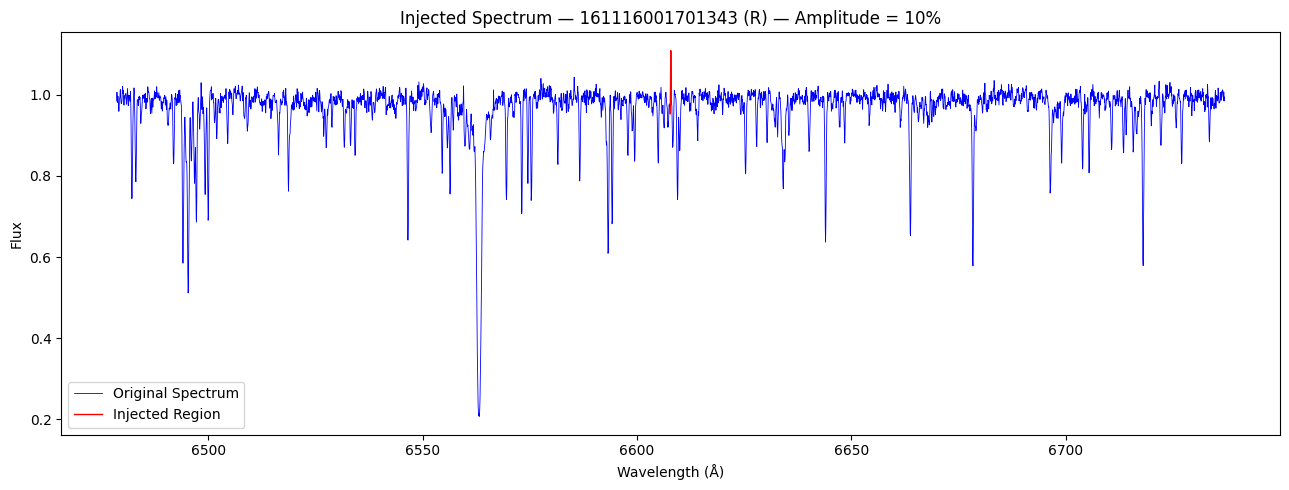

In [3]:
folder = "/datax/scratch/emmay/galah_spectra"
wavelength, flux_injected, flux_original, wav_injected = inject_and_plot_laser(
            obj_id=161116001701343, filt='R', folder=folder,
            laser_amp_percent=10,  # change this value as needed
            plot=True
        )

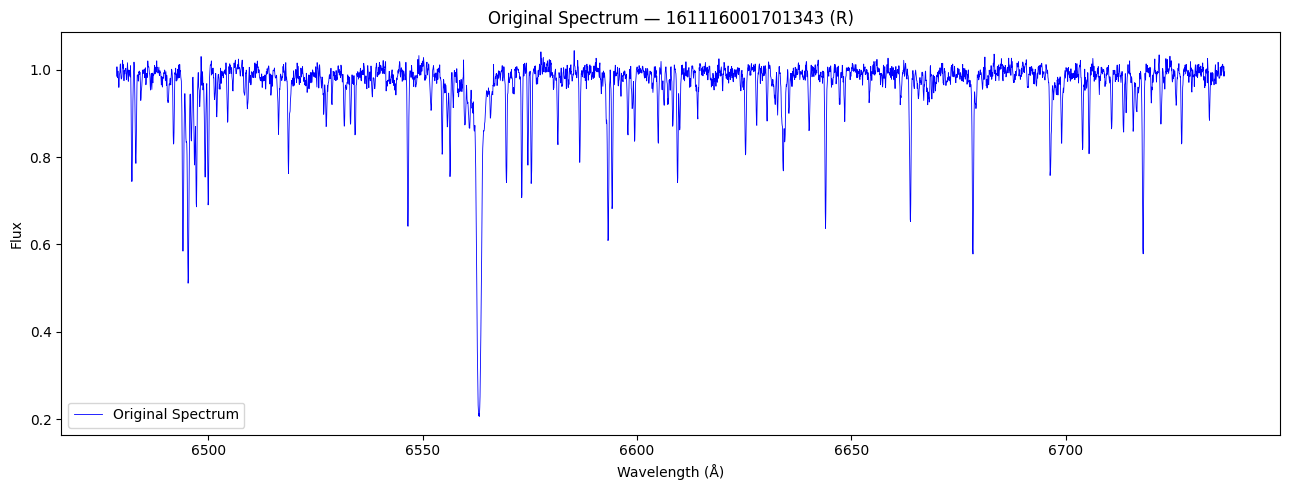

In [4]:
plt.figure(figsize=(13, 5))
plt.plot(wavelength, flux_original, color='blue', linewidth=0.6, label="Original Spectrum")
#plt.plot(wavelength[threshold_mask], flux_injected[threshold_mask], color='red', linewidth=1.0, label="Injected Region")
plt.xlabel("Wavelength (Å)")
plt.ylabel("Flux")
plt.title(f"Original Spectrum — 161116001701343 (R)")
plt.legend()
plt.tight_layout()
plt.show()

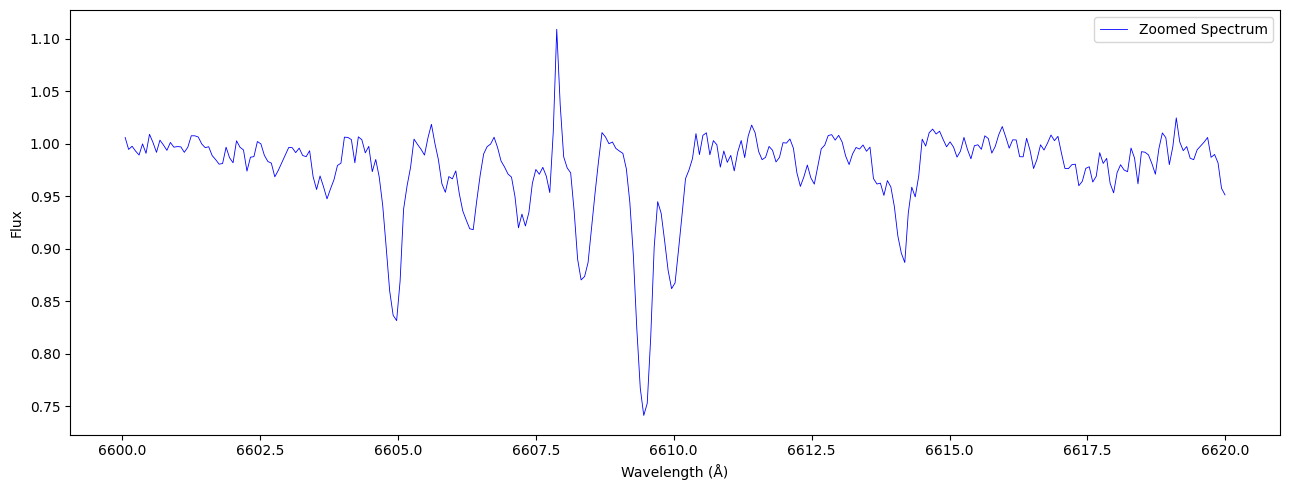

In [5]:
# Apply zoom mask for desired wavelength range
zoom_mask = (wavelength >= 6600) & (wavelength <= 6620)

# Plot zoomed region
plt.figure(figsize=(13, 5))
plt.plot(wavelength[zoom_mask], flux_injected[zoom_mask], color='blue', linewidth=0.6, label="Zoomed Spectrum")
plt.xlabel("Wavelength (Å)")
plt.ylabel("Flux")
plt.legend()
plt.tight_layout()
plt.show()


## Find Peak

In [6]:
def detect_laser_peak(wavelength, flux, width_range=(0, 10), height_fraction=0.05):
    """
    Detect a narrow injected laser peak in a spectrum.

    Parameters:
    ----------
    wavelength : array-like
        Wavelength axis (same shape as flux).
    flux : array-like
        Flux values.
    width_range : tuple
        Expected width range (in pixels) for the laser peak.
    height_fraction : float
        Fraction of max flux to use as a minimum height threshold.

    Returns:
    -------
    peak_indices : array
        Indices of detected peaks.
    peak_wavelengths : array
        Wavelengths of detected peaks.
    """

    # Set dynamic threshold: 10% of max flux by default
    height_threshold = height_fraction

    # Detect peaks
    peak_indices, properties = find_peaks(
        flux,
        threshold=height_threshold,
        #width=width_range
    )

    peak_wavelengths = wavelength[peak_indices]

    # Optional: plot
    plt.figure(figsize=(12, 5))
    plt.plot(wavelength, flux, label="Spectrum")
    plt.plot(wavelength[peak_indices], flux[peak_indices], 'rx', label="Detected Peaks")
    plt.xlabel("Wavelength (Å)")
    plt.ylabel("Flux (Counts)")
    plt.title("Laser Peak Detection")
    plt.legend()
    plt.tight_layout()
    plt.show()

    return peak_indices, peak_wavelengths


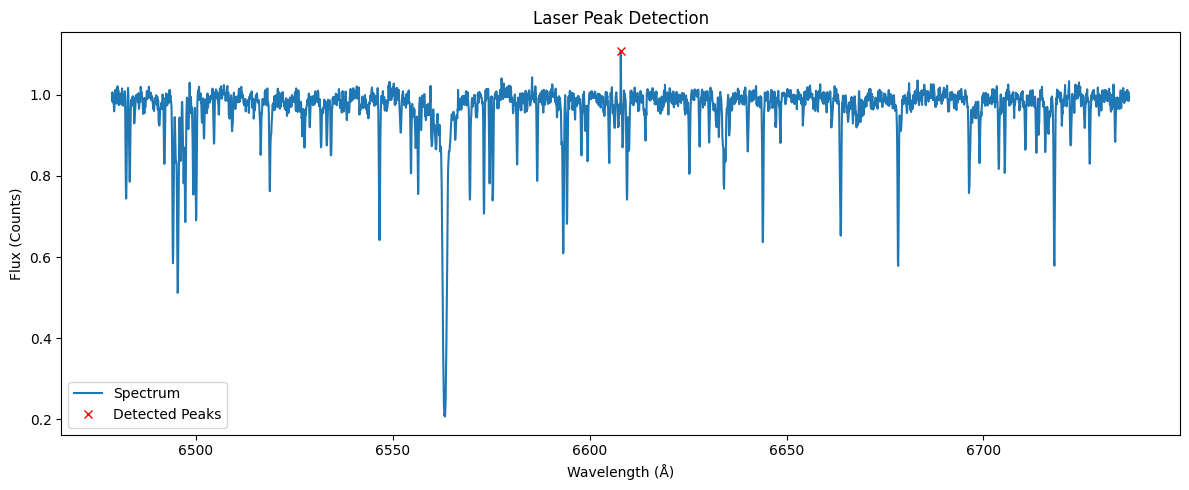

In [7]:
# Suppose you have wavelength and injected flux already from your previous code:
peak_indices, peak_wavelengths = detect_laser_peak(wavelength, flux_injected)


In [8]:

def measure_width_at_y(flux, wavelength, peak_idx, y_level=1):
    """Measure width of a peak at a fixed y_level using linear interpolation."""
    # Left side
    i = peak_idx
    while i > 0 and flux[i] > y_level:
        i -= 1
    if i == 0 or flux[i] > y_level:
        return None  # No valid left edge
    left = wavelength[i] + (y_level - flux[i]) / (flux[i+1] - flux[i]) * (wavelength[i+1] - wavelength[i])

    # Right side
    i = peak_idx
    while i < len(flux) - 1 and flux[i] > y_level:
        i += 1
    if i == len(flux) - 1 or flux[i] > y_level:
        return None  # No valid right edge
    right = wavelength[i-1] + (y_level - flux[i-1]) / (flux[i] - flux[i-1]) * (wavelength[i] - wavelength[i-1])

    return left, right, right - left

In [9]:
def detect_laser_peak_with_fixed_level_width(
    wavelength, 
    flux, 
    height_fraction=0.2, 
    y_level=1.0, 
    max_pixel_width=3,
    injected_wavelength=None,
    plot=True
):
    """
    Detect laser-like peaks and measure width above a fixed y-level.

    Parameters
    ----------
    wavelength : array
        Wavelength array.
    flux : array
        Flux array.
    height_fraction : float
        Threshold for peak prominence (fraction of max flux).
    y_level : float
        Fixed flux level at which to measure peak width.
    max_pixel_width : float
        Maximum allowed width in pixel units for valid peaks.
    plot : bool
        If True, show zoomed-in and full-spectrum plots.

    Returns
    -------
    peak_wavelengths : list of float
        Wavelengths of detected peaks.
    widths : list of float
        Widths measured at y_level.
    """

    # Remove units if present
    flux = np.asarray(flux)
    wavelength = np.asarray(wavelength)
        
    height_threshold = height_fraction * max(np.abs(flux - 1))
    peak_indices, properties = find_peaks(flux, height=height_threshold*np.nanmax(flux)+1)

    # Handle case where no peaks are found
    if len(peak_indices) == 0:
        print("No peaks detected.")
        if plot:
            plt.figure(figsize=(12, 4))
            plt.plot(wavelength, flux, label="Full Spectrum")
            if injected_wavelength is not None:
                plt.axvline(x=float(injected_wavelength.value), color='r', linestyle='--', linewidth=2, label="Injected Laser")
            plt.xlabel("Wavelength (Å)")
            plt.ylabel("Flux")
            plt.title("Full Spectrum (No Peaks Detected)")
            plt.legend()
            plt.tight_layout()
            plt.show()
        return [], []

    peak_wavelengths = []
    widths = []
    valid_peak_indices = []

    # Estimate pixel scale (assuming evenly spaced wavelength)
    pixel_scale = np.median(np.diff(wavelength))

    for i, idx in enumerate(peak_indices):
        result = measure_width_at_y(flux, wavelength, idx, y_level=y_level)
        if result is not None:
            left, right, width = result
            print(type(left),type(right),type(width))
            width_in_pixels = width / pixel_scale

            if width_in_pixels > max_pixel_width:
                continue  # Skip wide peaks

            peak_wavelengths.append(wavelength[idx])
            widths.append(width)
            valid_peak_indices.append(idx)

            if plot:
                i_min = max(0, idx - 20)
                i_max = min(len(wavelength), idx + 20)

                plt.figure(figsize=(10, 4))
                plt.plot(wavelength[i_min:i_max], flux[i_min:i_max], label="Flux")
                plt.axvline(left, color='C2', linestyle='--')
                plt.axvline(right, color='C2', linestyle='--')
                plt.hlines(y_level, left, right, color='C3', linewidth=2, label=f'Width @ y={y_level}')
                plt.plot(wavelength[idx], flux[idx], 'rx', label="Peak Center")
                plt.xlabel("Wavelength (Å)")
                plt.ylabel("Flux")
                plt.title(f"Zoomed Peak at {wavelength[idx]:.2f} Å, Width = {width:.3f} Å ({width_in_pixels:.2f} px)")
                plt.legend()
                plt.tight_layout()
                plt.show()
                
    # Plot full spectrum with vertical lines
    if plot and valid_peak_indices:
        plt.figure(figsize=(12, 4))
        plt.plot(wavelength, flux, label="Full Spectrum")
        for idx in valid_peak_indices:
            #plt.axvline(wavelength[idx], color='blue', linestyle='--', alpha=0.7)
            plt.plot(wavelength[idx], flux[idx], 'rx', label="Detected Peaks")


        if injected_wavelength is not None:
            plt.axvline(x=float(injected_wavelength.value), color='black', linestyle='--', linewidth=2, label="Injected Laser")

        plt.xlabel("Wavelength (Å)")
        plt.ylabel("Flux")
        plt.title("Full Spectrum with Detected Peaks")
        plt.legend()
        plt.tight_layout()
        plt.show()

    return peak_wavelengths, widths


In [26]:
def evaluate_detection(injected_wavelengths, detected_wavelengths, threshold_angstroms=2.0):
    """
    Compare injected laser wavelengths to detected peaks and compute performance metrics.

    Parameters:
    - injected_wavelengths: list of float or Quantity
    - detected_wavelengths: list of float or Quantity
    - threshold_angstroms: float, matching window in angstroms

    Returns:
    - stats: dict with TP, FP, FN, precision, recall, F1, n_injected, n_detected
    - matched_flags: list of bool per injected wavelength
    """
    def to_angstroms(wl):
        return float(wl.to_value('angstrom')) if hasattr(wl, 'to_value') else float(wl)

    injected_wavelengths = [to_angstroms(wl) for wl in injected_wavelengths]
    detected_wavelengths = [to_angstroms(wl) for wl in detected_wavelengths]

    matched_injected = [False] * len(injected_wavelengths)
    matched_detected = [False] * len(detected_wavelengths)

    for i, inj_wl in enumerate(injected_wavelengths):
        for j, det_wl in enumerate(detected_wavelengths):
            if not matched_detected[j] and abs(det_wl - inj_wl) <= threshold_angstroms:
                matched_injected[i] = True
                matched_detected[j] = True
                break

    TP = sum(matched_injected)
    FN = len(injected_wavelengths) - TP
    FP = len(detected_wavelengths) - TP

    precision = TP / (TP + FP) if (TP + FP) > 0 else 0.0
    recall = TP / (TP + FN) if (TP + FN) > 0 else 0.0
    f1 = 2 * precision * recall / (precision + recall) if (precision + recall) > 0 else 0.0

    stats = {
        "TP": TP,
        "FP": FP,
        "FN": FN,
        "precision": precision,
        "recall": recall,
        "f1_score": f1,
        "n_injected": len(injected_wavelengths),
        "n_detected": len(detected_wavelengths)
    }

    return stats, matched_injected


No peaks detected.


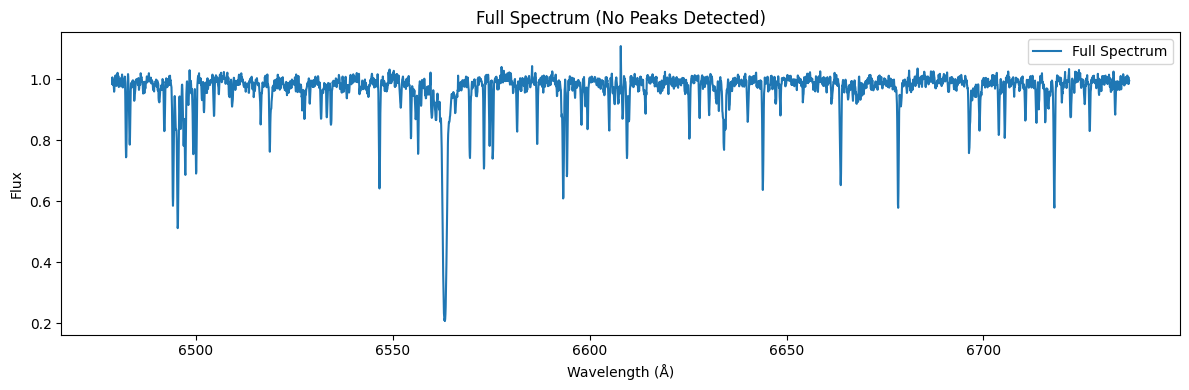

In [10]:
peak_waves, peak_widths = detect_laser_peak_with_fixed_level_width(wavelength, flux_injected, y_level=1.0)


In [11]:
0.5*max(np.abs(flux_injected - 1))

np.float64(0.39671406894922256)

Processing: 170910004101116_V


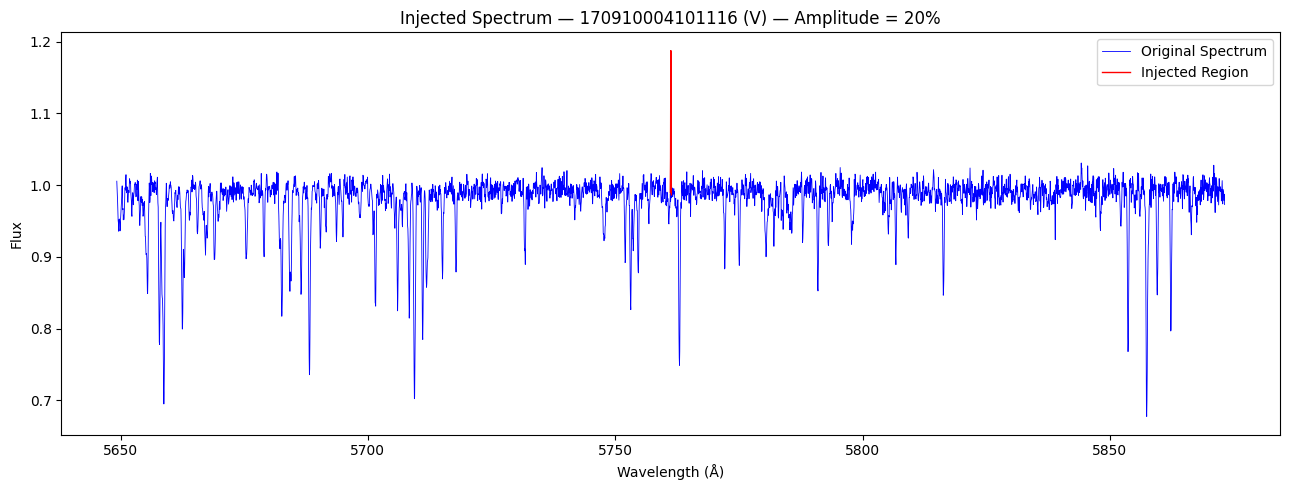

Injected laser success
<class 'numpy.float64'> <class 'numpy.float64'> <class 'numpy.float64'>


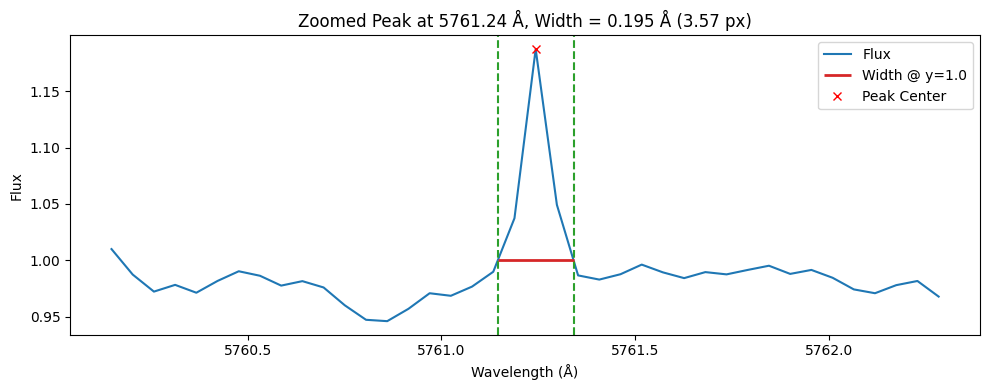

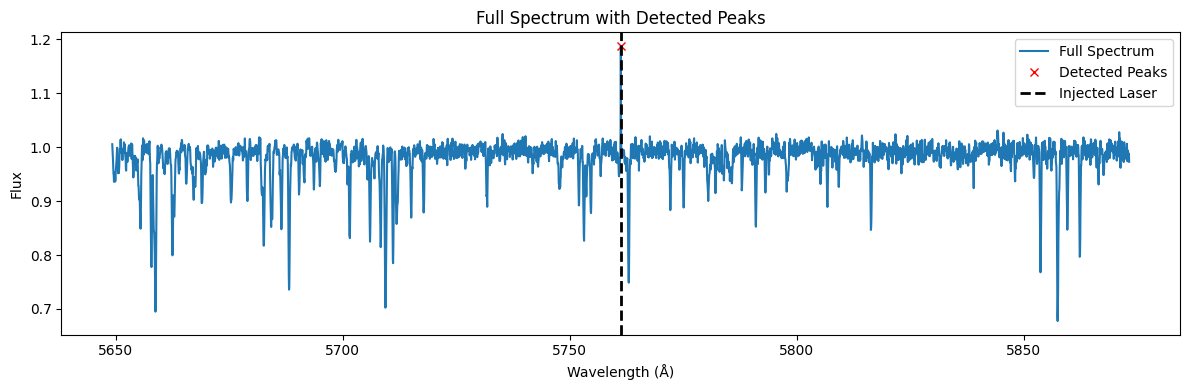

detection func success
Injected at 5761.24 Angstrom Å — RECOVERED ✅
Detected 1 peaks vs 1 injections
Precision: 100.00%
Recall: 100.00%
F1 Score: 100.00%
[np.float64(5761.242920458407)]


In [32]:
import os
import numpy as np

# Set up the path and file info
folder = "/datax/scratch/emmay/galah_spectra"
fits_file = "170910004101116_V.fits"
filename_no_ext = fits_file[:-5]  # Removes ".fits"
obj_id = filename_no_ext[:15]
filt = filename_no_ext[16:]  # Skip underscore at index 15

print(f"Processing: {obj_id}_{filt}")

# Step 1: Inject laser
wave, flux, injected_wl, wav_injected = inject_and_plot_laser(obj_id, filt, folder=folder, plot=True)
print("Injected laser success")

# Step 2: Try to detect it
detected_wavelengths, _ = detect_laser_peak_with_fixed_level_width(
    wave, flux, height_fraction=0.15, y_level=1.0, max_pixel_width=5, injected_wavelength=wav_injected, plot=True
)
print("detection func success")


# Step 3: Report
injected_wavelengths = [wav_injected]

stats, matched = evaluate_detection(
    injected_wavelengths = [wav_injected],

    # Flatten detected peaks if nested
    detected_wavelengths = detected_wavelengths,
    threshold_angstroms=2.0
)

for i, was_found in enumerate(matched):
    print(f"Injected at {injected_wavelengths[i]:.2f} Å — {'RECOVERED ✅' if was_found else 'NOT FOUND ❌'}")

print(f"Detected {stats['n_detected']} peaks vs {stats['n_injected']} injections")
print(f"Precision: {stats['precision']:.2%}")
print(f"Recall: {stats['recall']:.2%}")
print(f"F1 Score: {stats['f1_score']:.2%}")
print(detected_wavelengths)

## Inject and Recover Laser Loop for Multiple Objects

Processing: 161116001701343_B


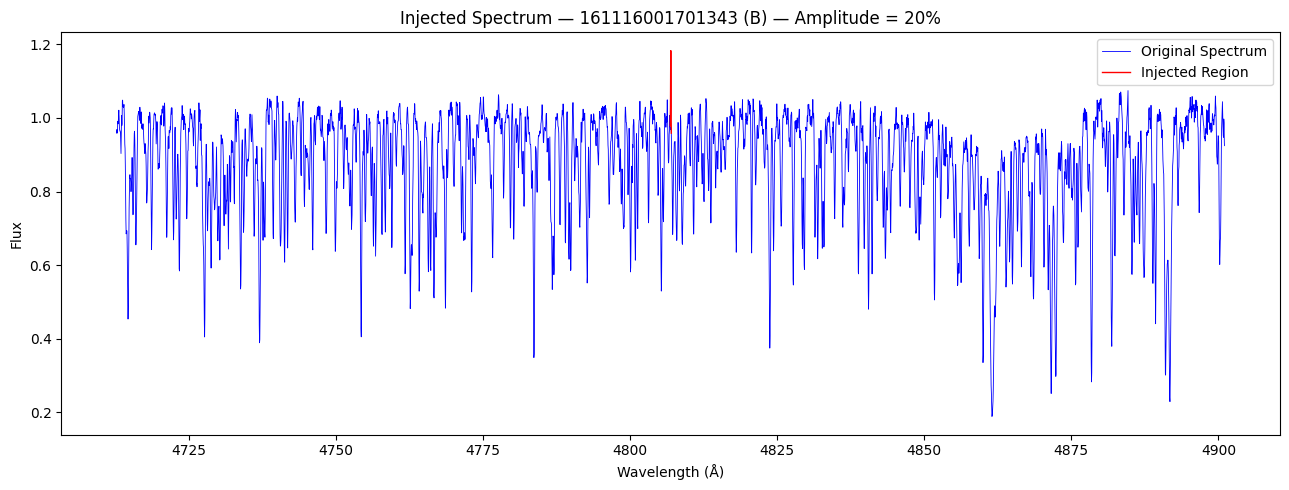

Injected laser success
<class 'numpy.float64'> <class 'numpy.float64'> <class 'numpy.float64'>


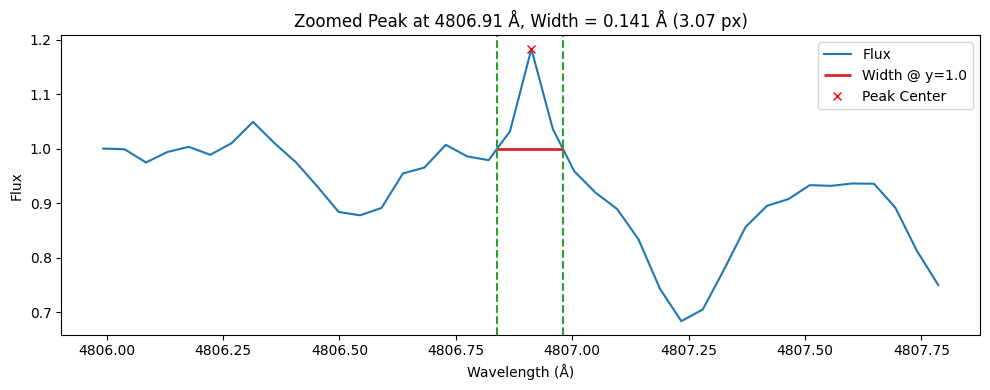

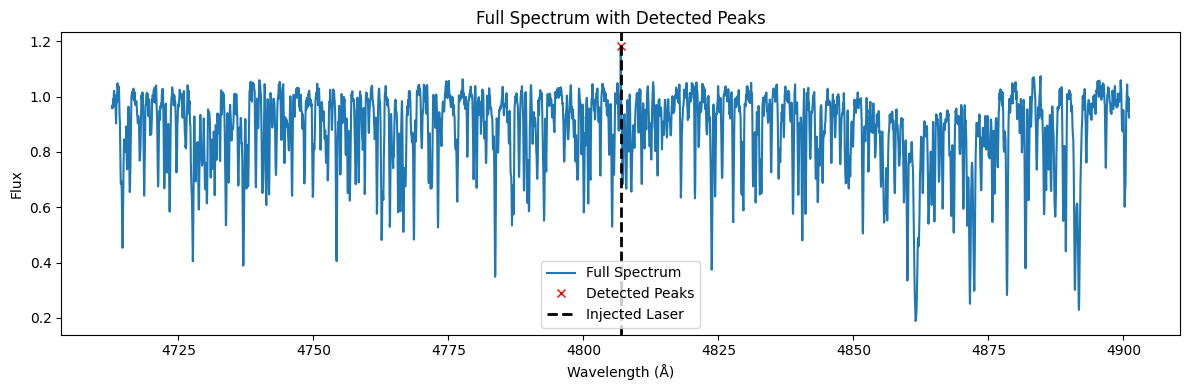

detection func success
Injected at 4806.91 Angstrom Å — RECOVERED ✅
Detected 1 peaks vs 1 injections
Precision: 100.00%
Recall: 100.00%
F1 Score: 100.00%
[np.float64(4806.912399362791)]
Processing: 161116001701343_V


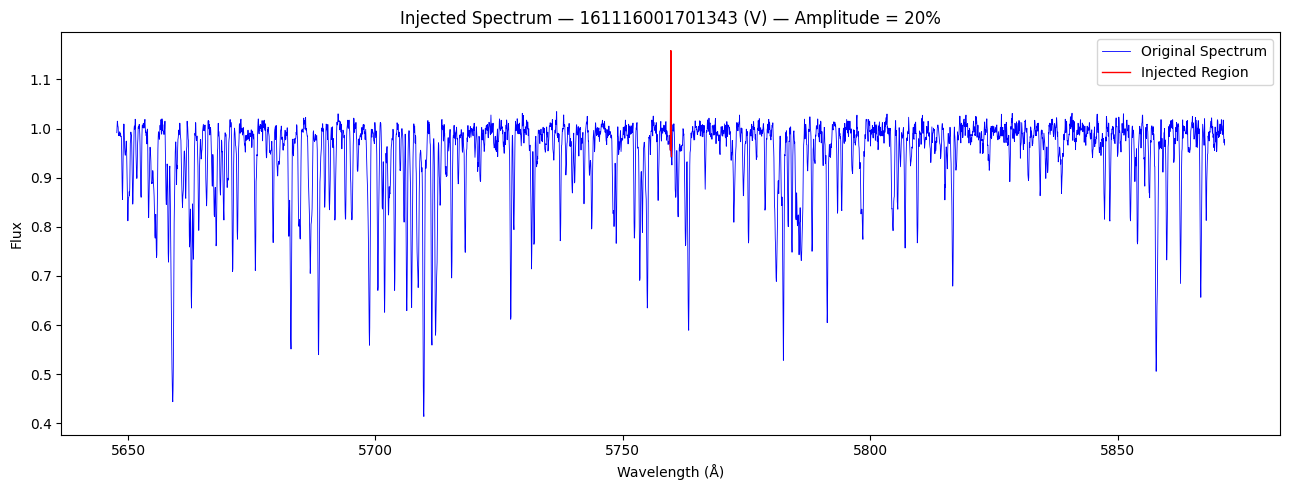

Injected laser success
<class 'numpy.float64'> <class 'numpy.float64'> <class 'numpy.float64'>


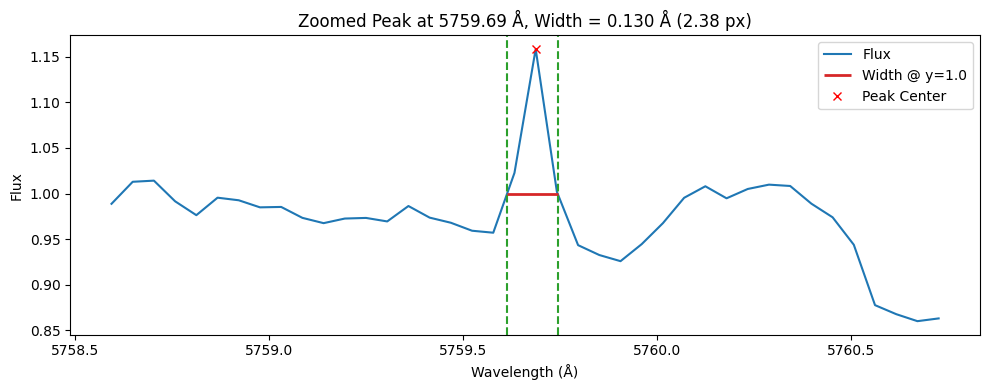

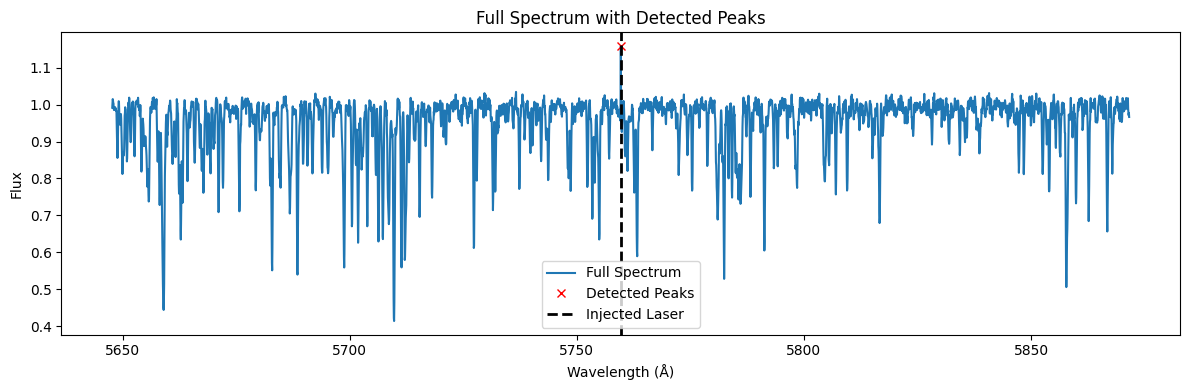

detection func success
Injected at 5759.69 Angstrom Å — RECOVERED ✅
Detected 1 peaks vs 1 injections
Precision: 100.00%
Recall: 100.00%
F1 Score: 100.00%
[np.float64(5759.687732514892)]
Processing: 161116001701343_R


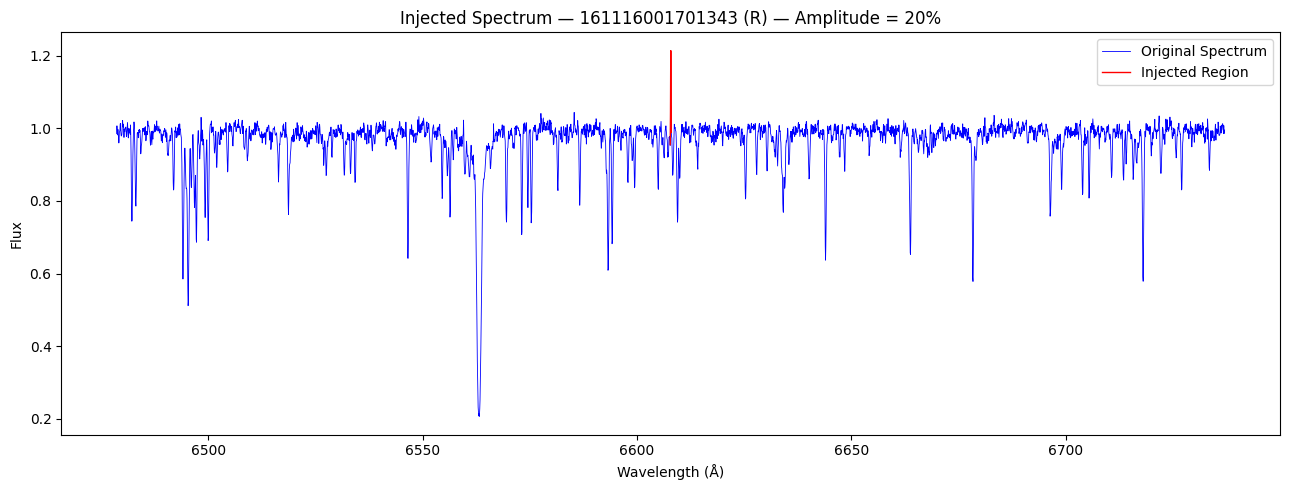

Injected laser success
<class 'numpy.float64'> <class 'numpy.float64'> <class 'numpy.float64'>


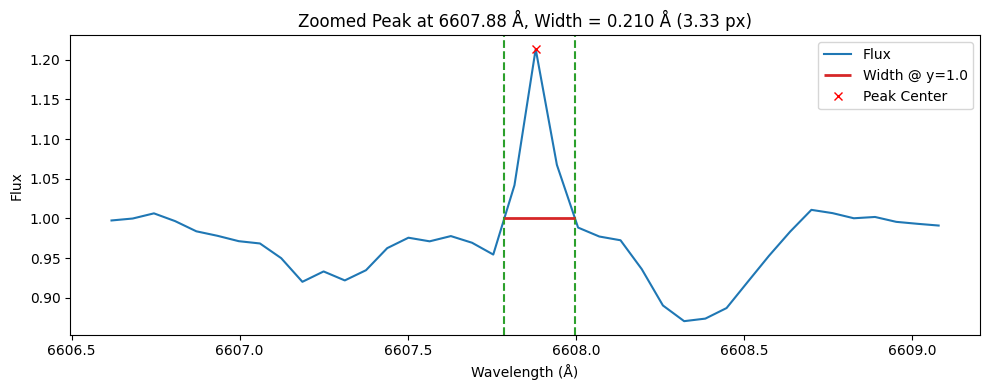

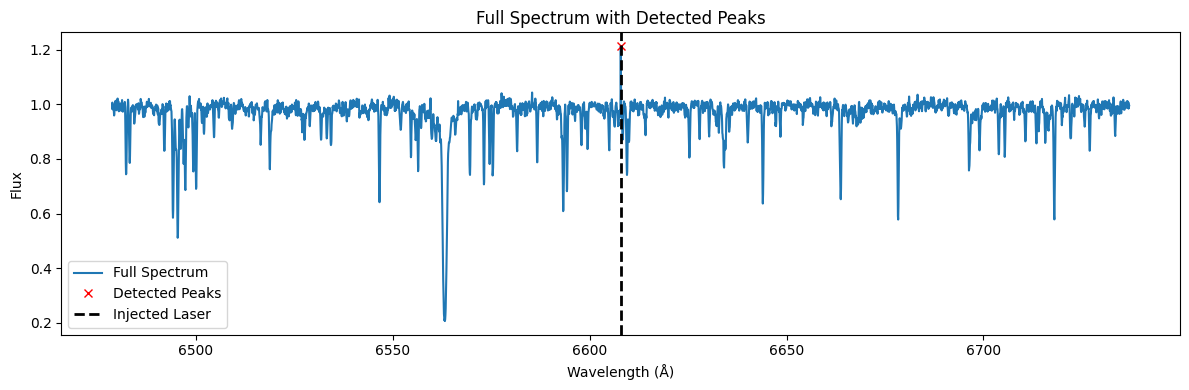

detection func success
Injected at 6607.88 Angstrom Å — RECOVERED ✅
Detected 1 peaks vs 1 injections
Precision: 100.00%
Recall: 100.00%
F1 Score: 100.00%
[np.float64(6607.8806627508375)]
Processing: 161116001701343_I


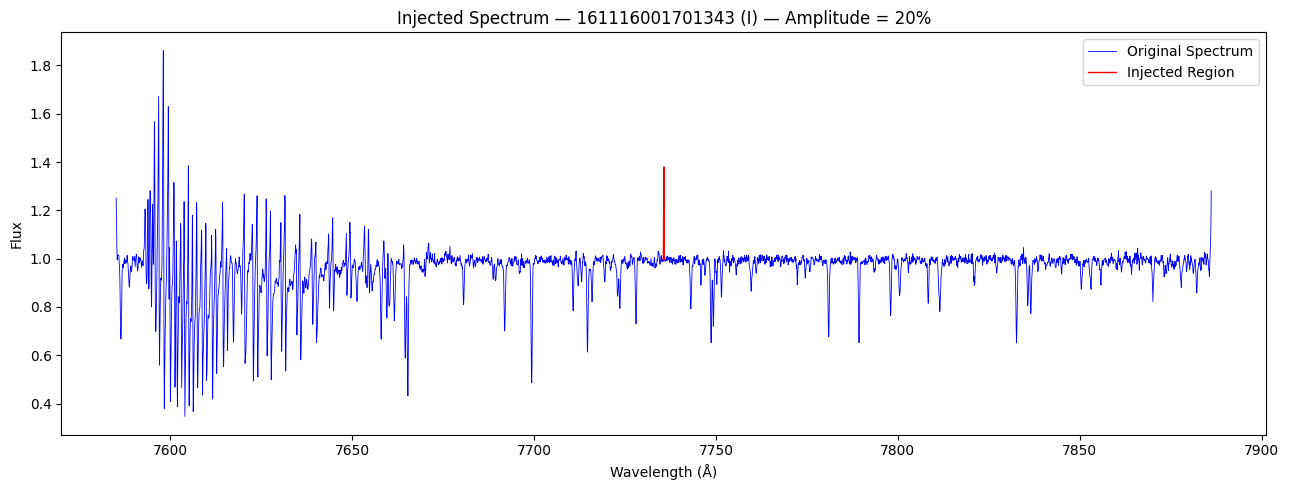

Injected laser success
<class 'numpy.float64'> <class 'numpy.float64'> <class 'numpy.float64'>


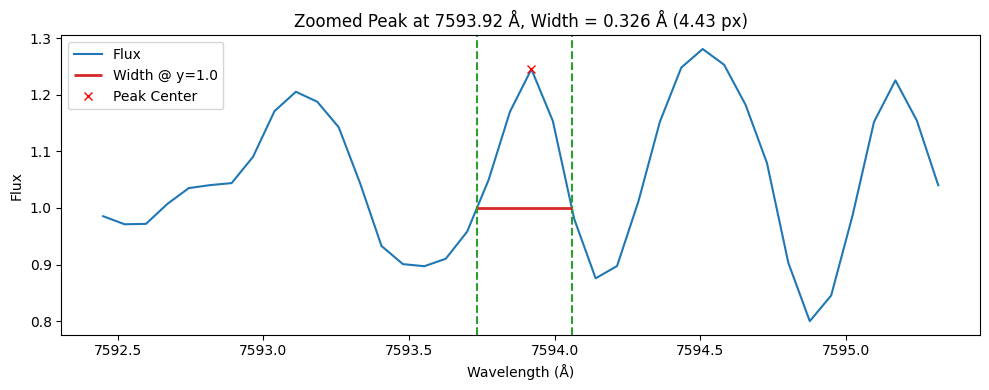

<class 'numpy.float64'> <class 'numpy.float64'> <class 'numpy.float64'>
<class 'numpy.float64'> <class 'numpy.float64'> <class 'numpy.float64'>
<class 'numpy.float64'> <class 'numpy.float64'> <class 'numpy.float64'>
<class 'numpy.float64'> <class 'numpy.float64'> <class 'numpy.float64'>
<class 'numpy.float64'> <class 'numpy.float64'> <class 'numpy.float64'>
<class 'numpy.float64'> <class 'numpy.float64'> <class 'numpy.float64'>
<class 'numpy.float64'> <class 'numpy.float64'> <class 'numpy.float64'>


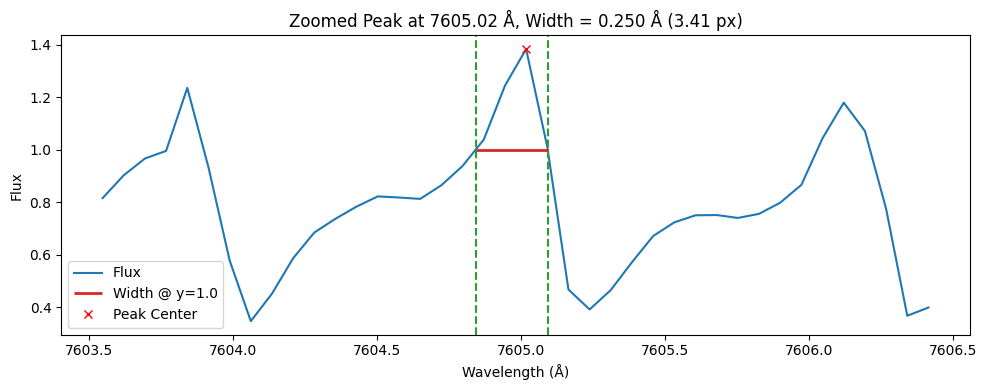

<class 'numpy.float64'> <class 'numpy.float64'> <class 'numpy.float64'>
<class 'numpy.float64'> <class 'numpy.float64'> <class 'numpy.float64'>
<class 'numpy.float64'> <class 'numpy.float64'> <class 'numpy.float64'>


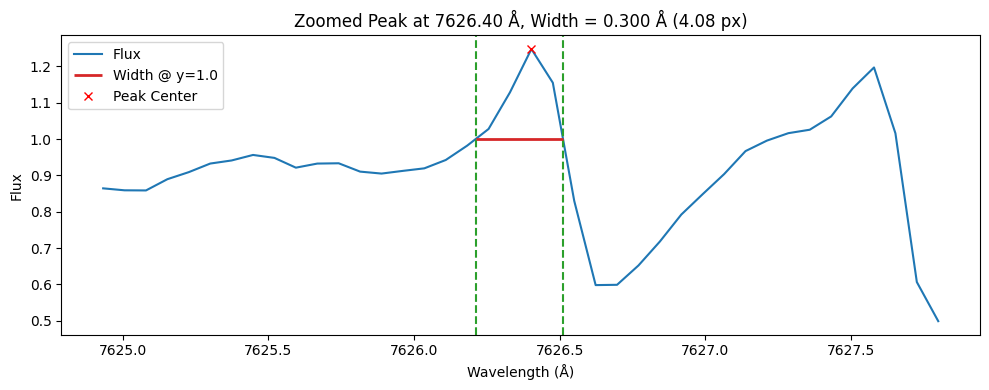

<class 'numpy.float64'> <class 'numpy.float64'> <class 'numpy.float64'>
<class 'numpy.float64'> <class 'numpy.float64'> <class 'numpy.float64'>


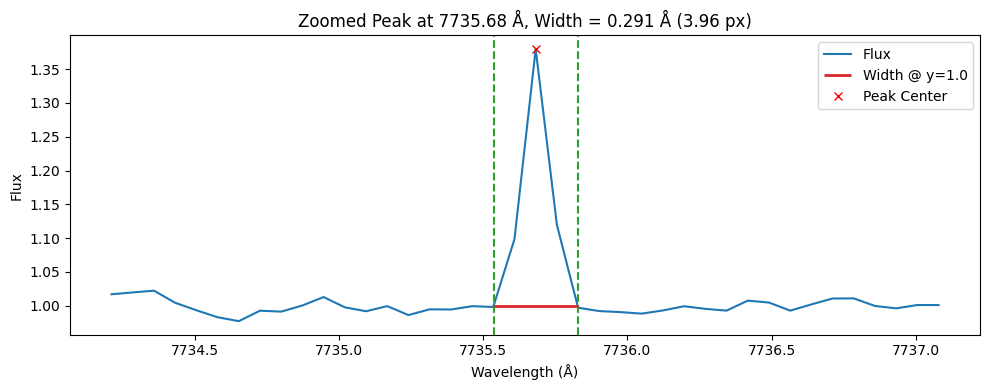

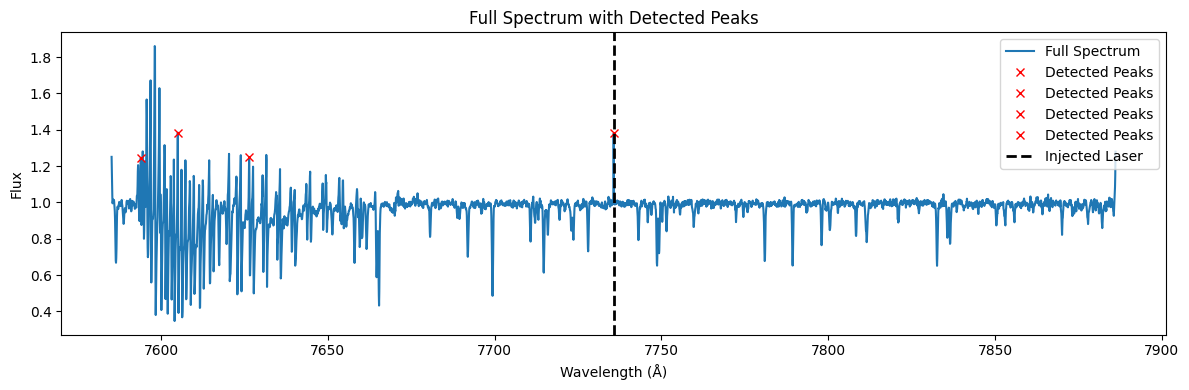

detection func success
Injected at 7735.68 Angstrom Å — RECOVERED ✅
Detected 4 peaks vs 1 injections
Precision: 25.00%
Recall: 100.00%
F1 Score: 40.00%
[np.float64(7593.9200963207895), np.float64(7605.01706301512), np.float64(7626.402608101544), np.float64(7735.682008594713)]
Processing: 170910004101116_B


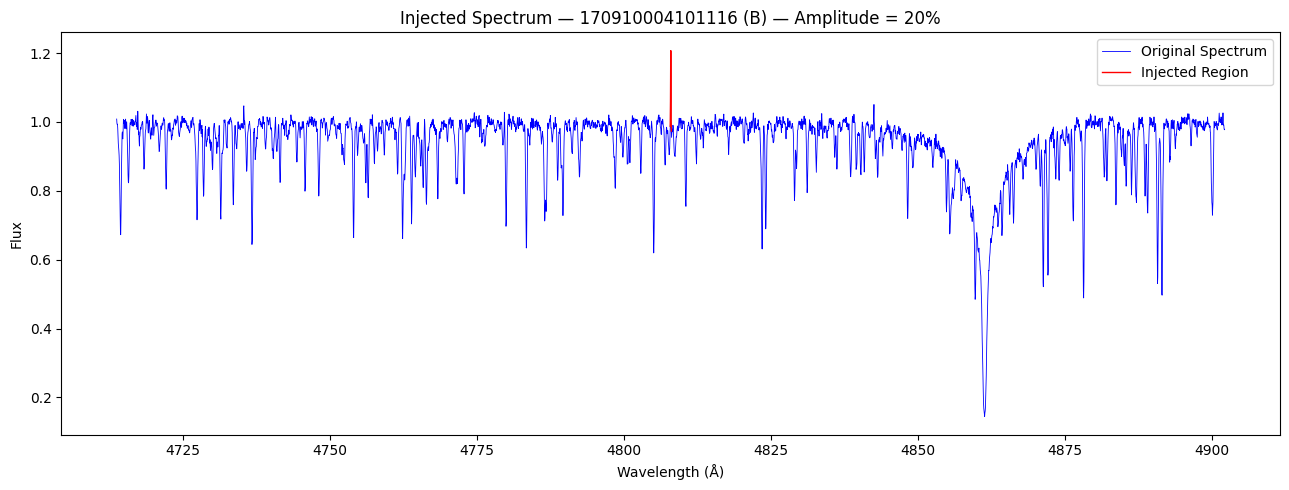

Injected laser success
<class 'numpy.float64'> <class 'numpy.float64'> <class 'numpy.float64'>


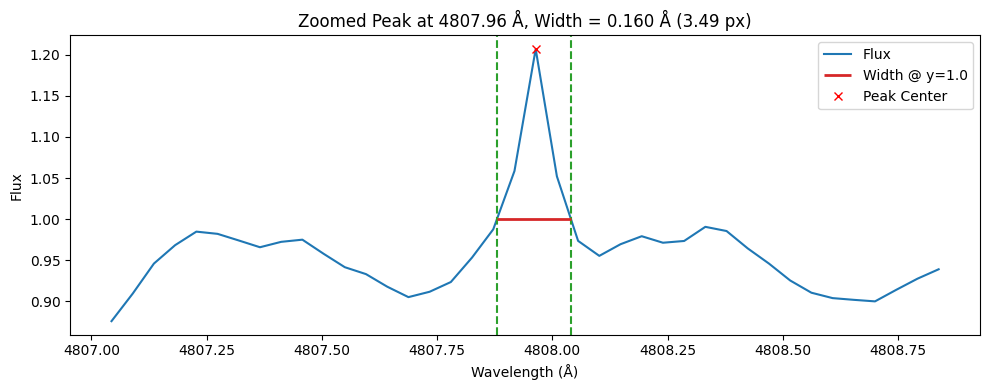

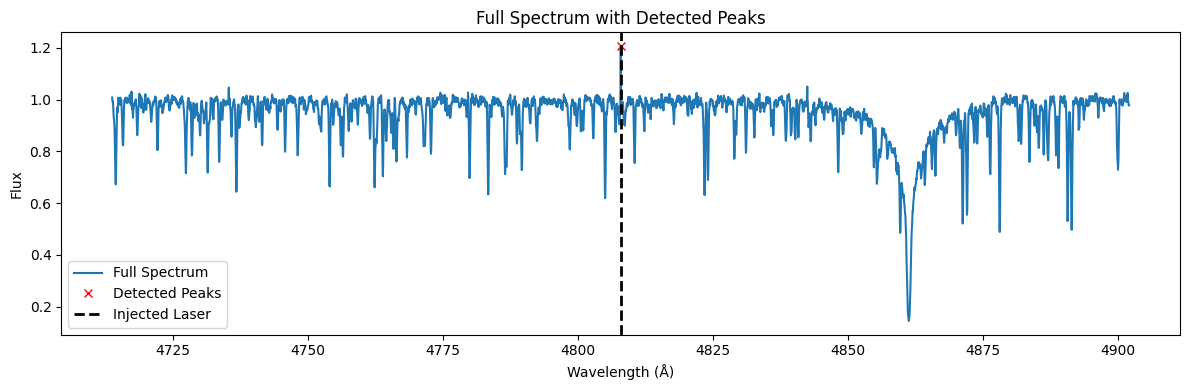

detection func success
Injected at 4807.96 Angstrom Å — RECOVERED ✅
Detected 1 peaks vs 1 injections
Precision: 100.00%
Recall: 100.00%
F1 Score: 100.00%
[np.float64(4807.9639232295485)]
Processing: 170910004101116_V


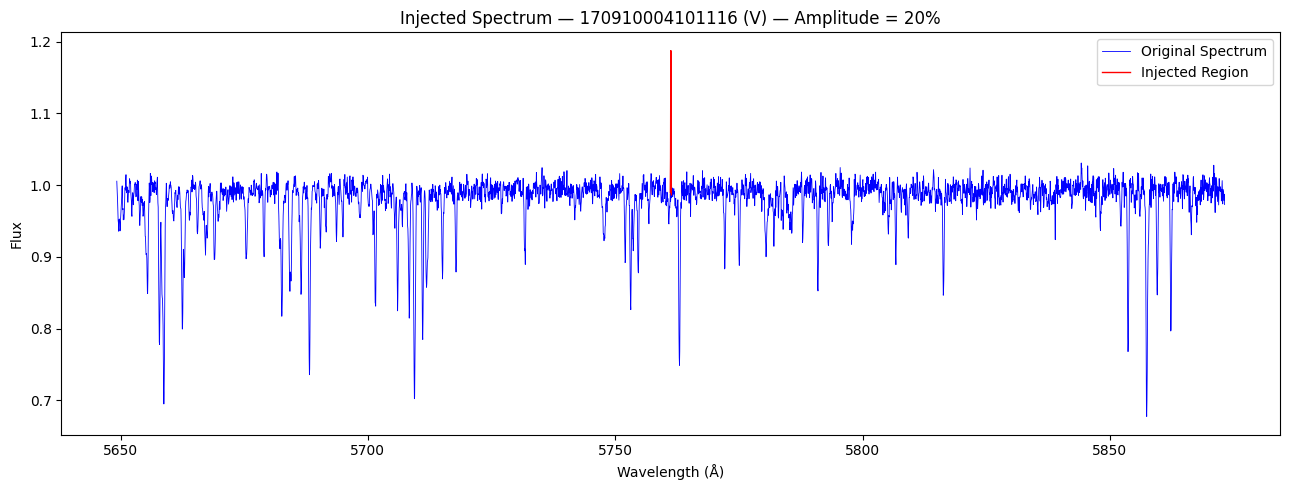

Injected laser success
<class 'numpy.float64'> <class 'numpy.float64'> <class 'numpy.float64'>


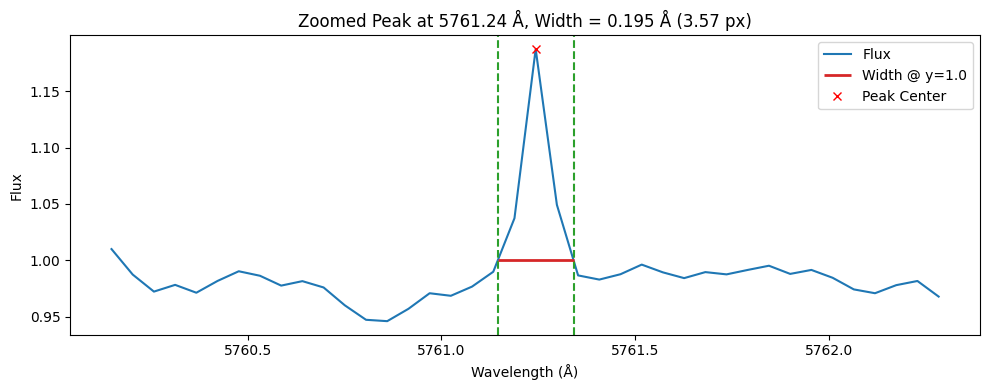

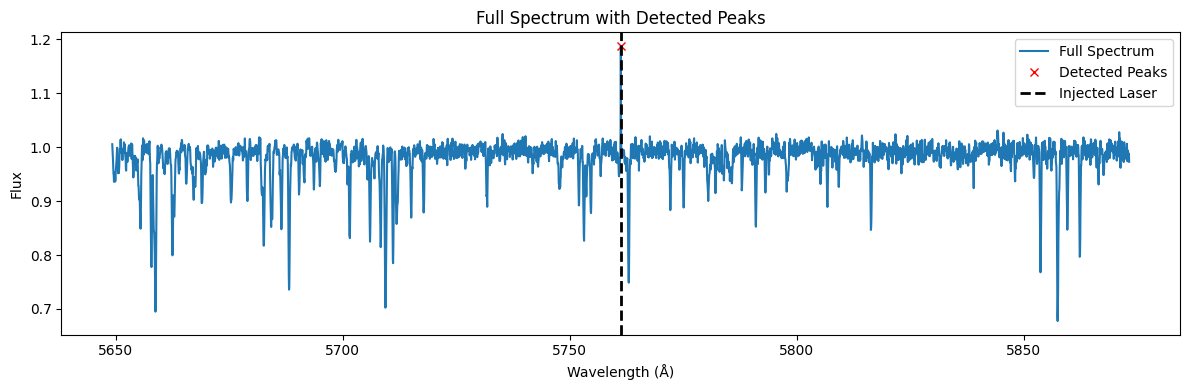

detection func success
Injected at 5761.24 Angstrom Å — RECOVERED ✅
Detected 1 peaks vs 1 injections
Precision: 100.00%
Recall: 100.00%
F1 Score: 100.00%
[np.float64(5761.242920458407)]
Processing: 170910004101116_R


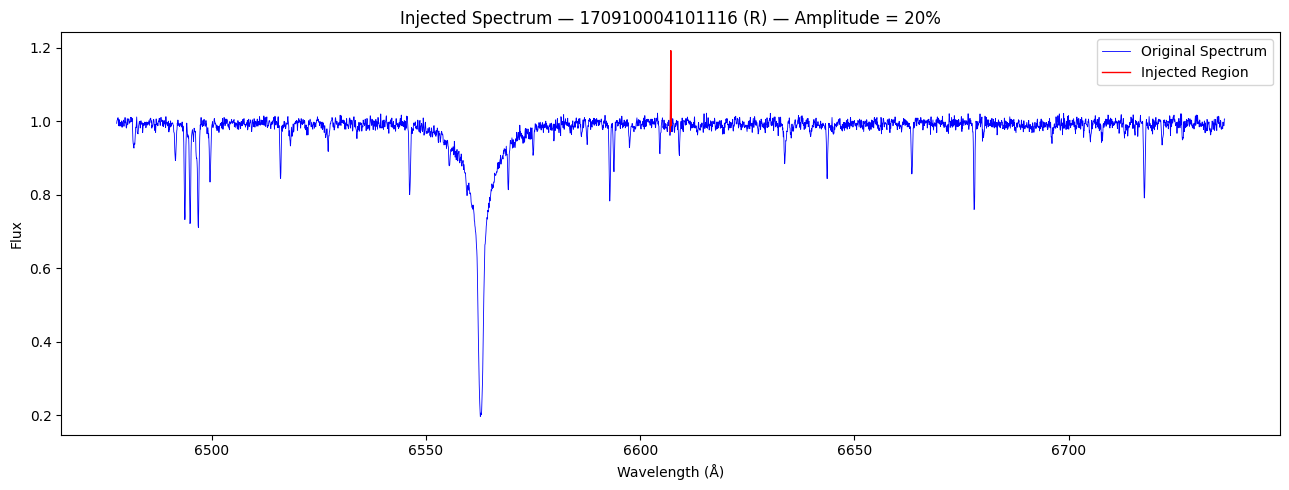

Injected laser success
<class 'numpy.float64'> <class 'numpy.float64'> <class 'numpy.float64'>


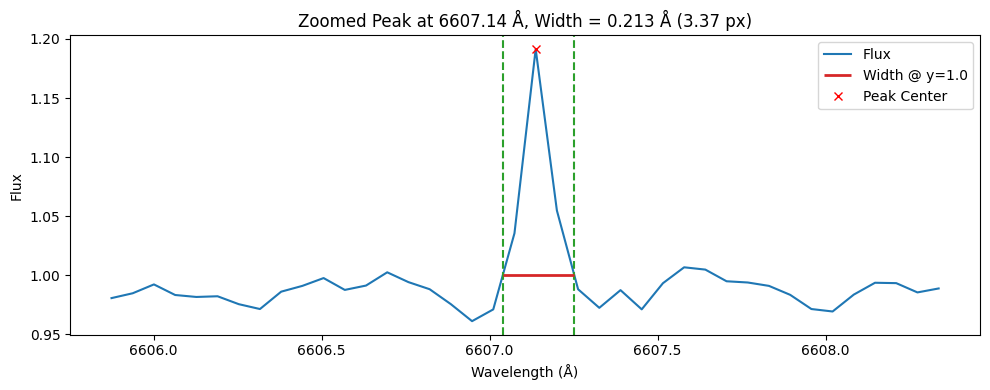

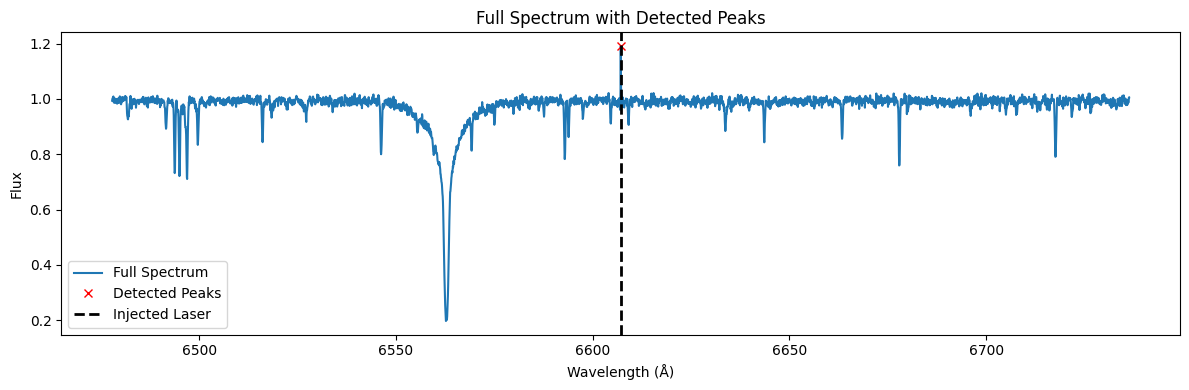

detection func success
Injected at 6607.14 Angstrom Å — RECOVERED ✅
Detected 1 peaks vs 1 injections
Precision: 100.00%
Recall: 100.00%
F1 Score: 100.00%
[np.float64(6607.137278097296)]
Processing: 170910004101116_I


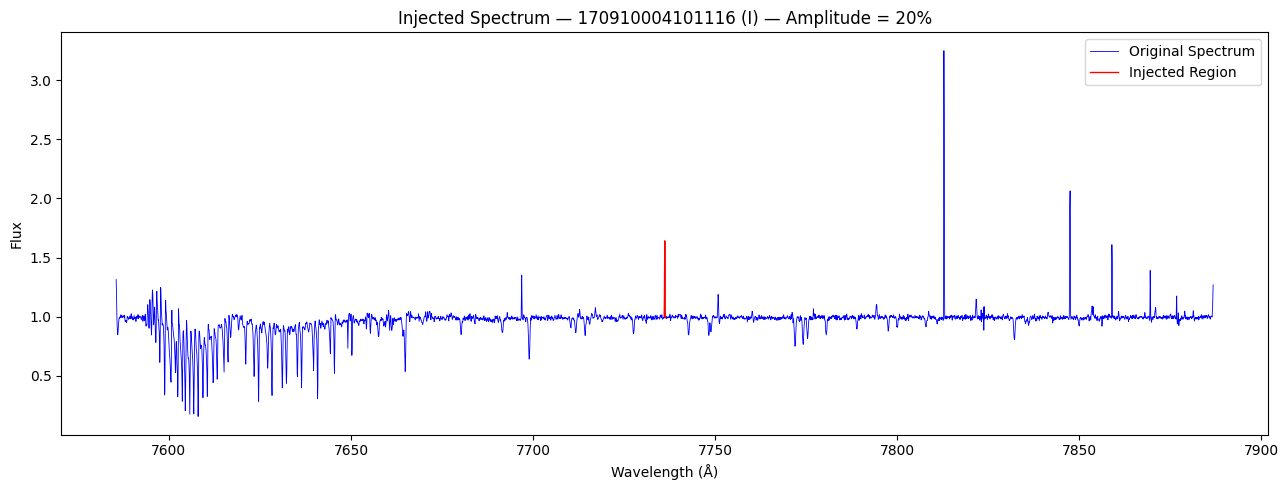

Injected laser success
<class 'numpy.float64'> <class 'numpy.float64'> <class 'numpy.float64'>


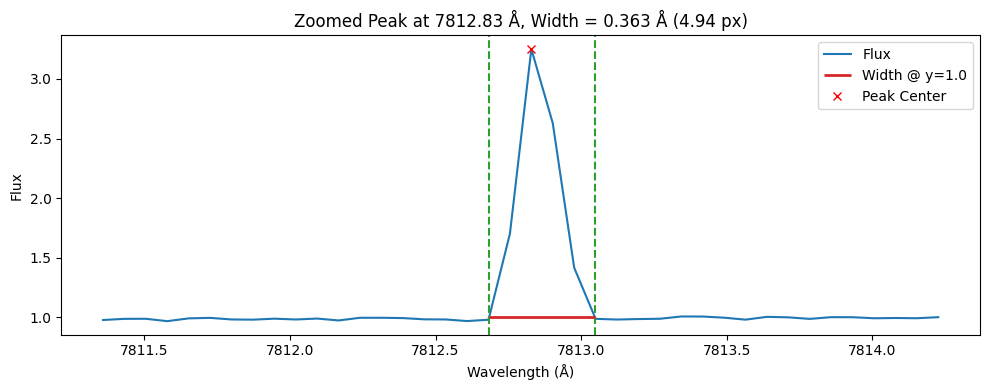

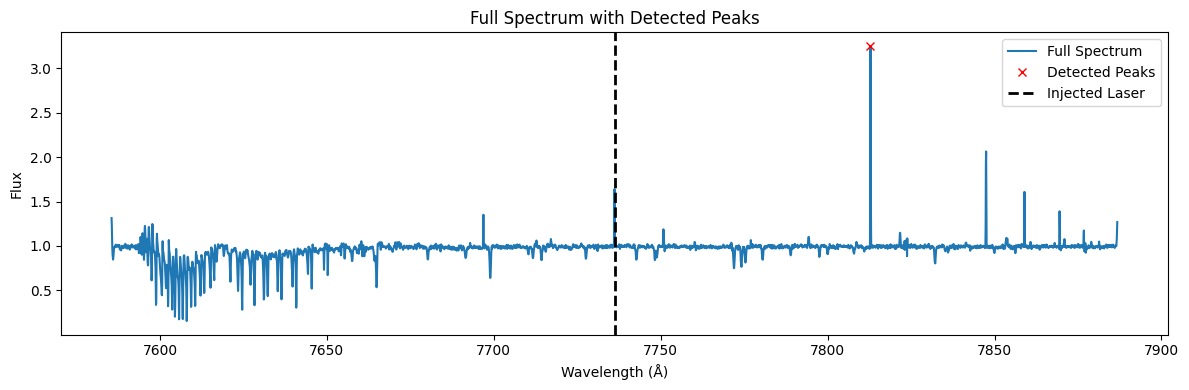

detection func success
Injected at 7736.17 Angstrom Å — NOT FOUND ❌
Detected 1 peaks vs 1 injections
Precision: 0.00%
Recall: 0.00%
F1 Score: 0.00%
[np.float64(7812.829221397154)]
Processing: 161118002501241_B


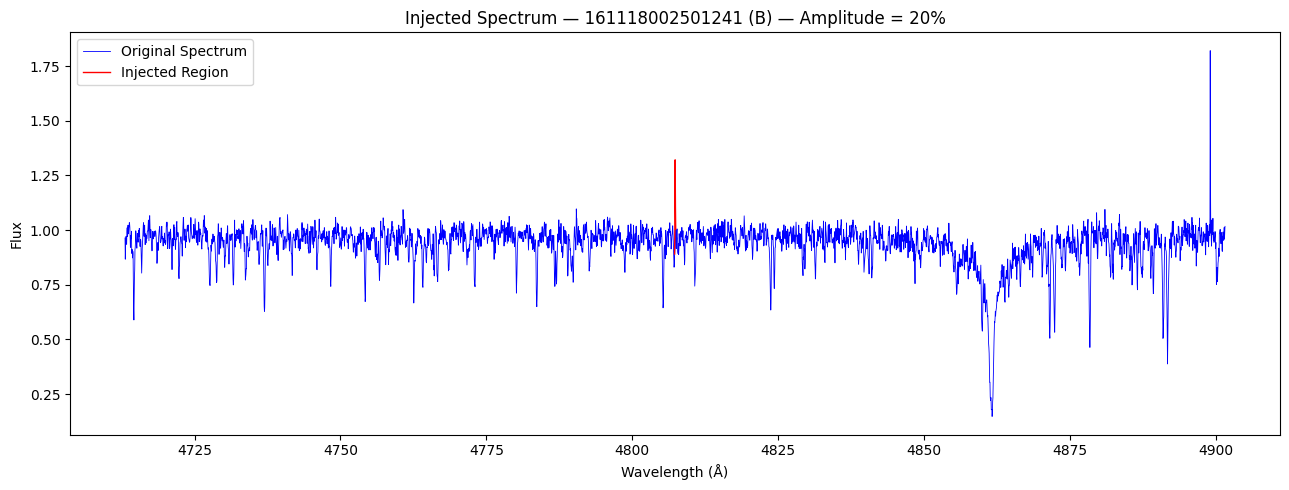

Injected laser success
<class 'numpy.float64'> <class 'numpy.float64'> <class 'numpy.float64'>


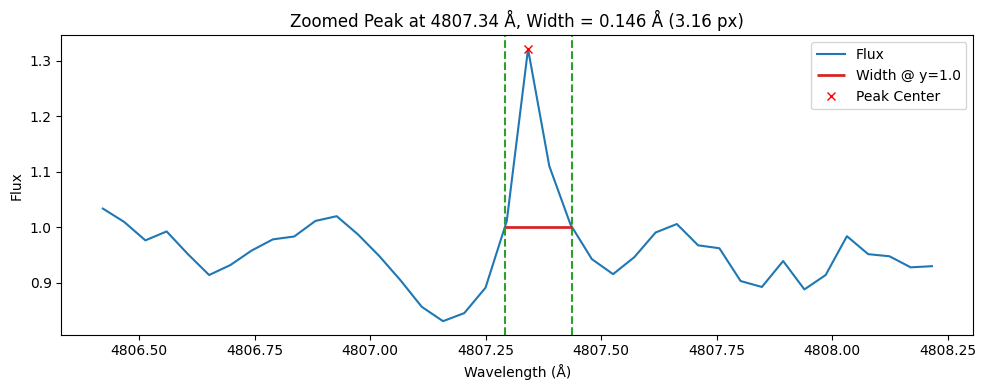

<class 'numpy.float64'> <class 'numpy.float64'> <class 'numpy.float64'>


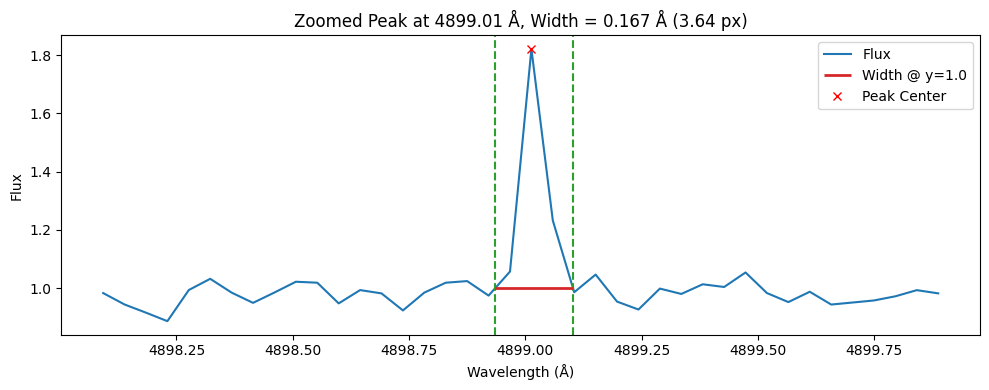

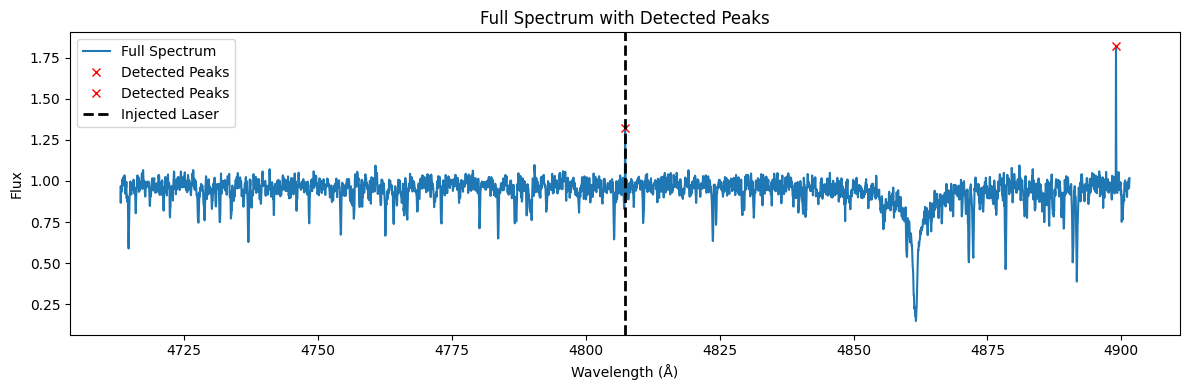

detection func success
Injected at 4807.34 Angstrom Å — RECOVERED ✅
Detected 2 peaks vs 1 injections
Precision: 50.00%
Recall: 100.00%
F1 Score: 66.67%
[np.float64(4807.3418574481075), np.float64(4899.01286820818)]
Processing: 161118002501241_V


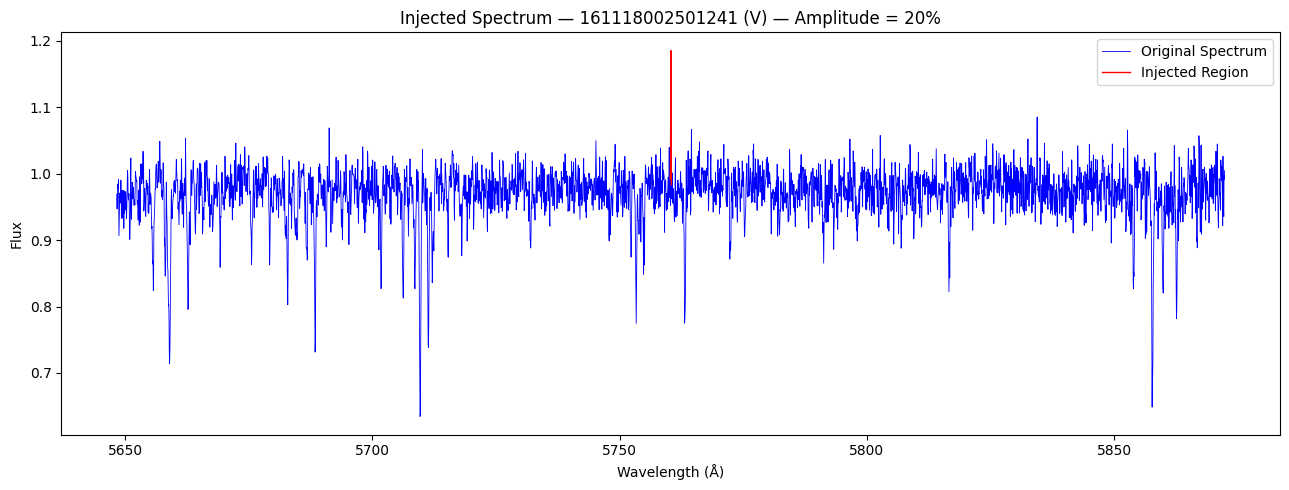

Injected laser success
<class 'numpy.float64'> <class 'numpy.float64'> <class 'numpy.float64'>


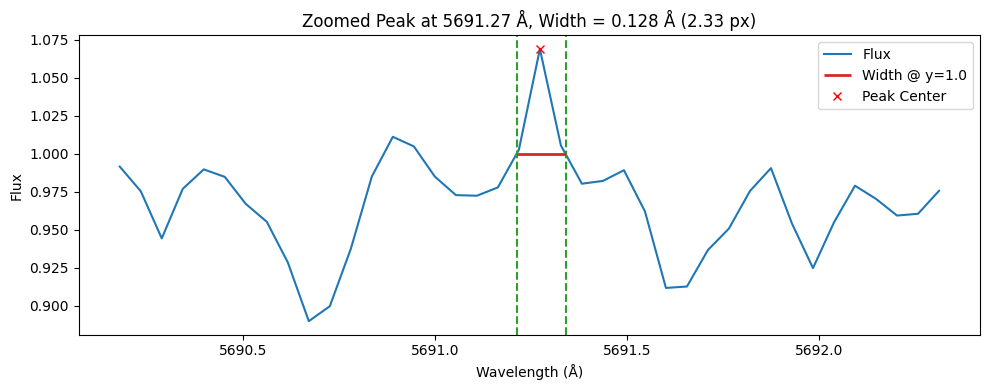

<class 'numpy.float64'> <class 'numpy.float64'> <class 'numpy.float64'>


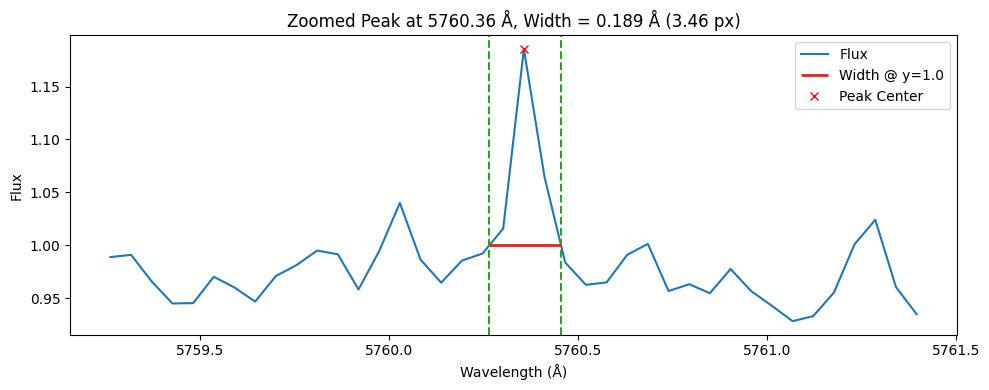

<class 'numpy.float64'> <class 'numpy.float64'> <class 'numpy.float64'>


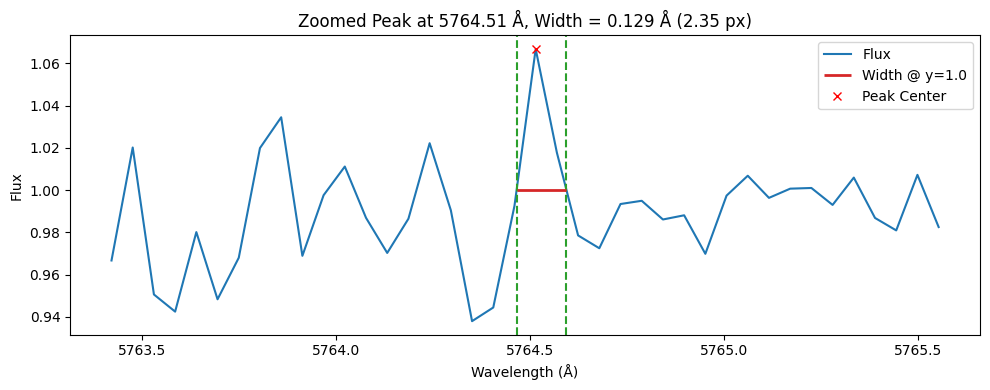

<class 'numpy.float64'> <class 'numpy.float64'> <class 'numpy.float64'>


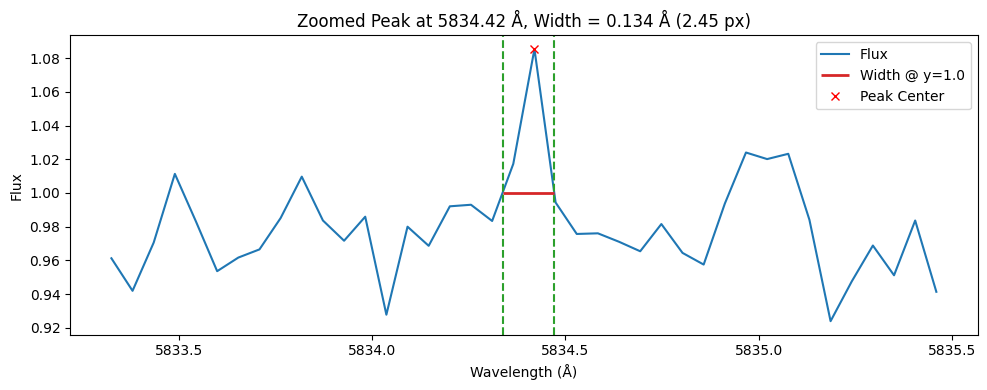

<class 'numpy.float64'> <class 'numpy.float64'> <class 'numpy.float64'>


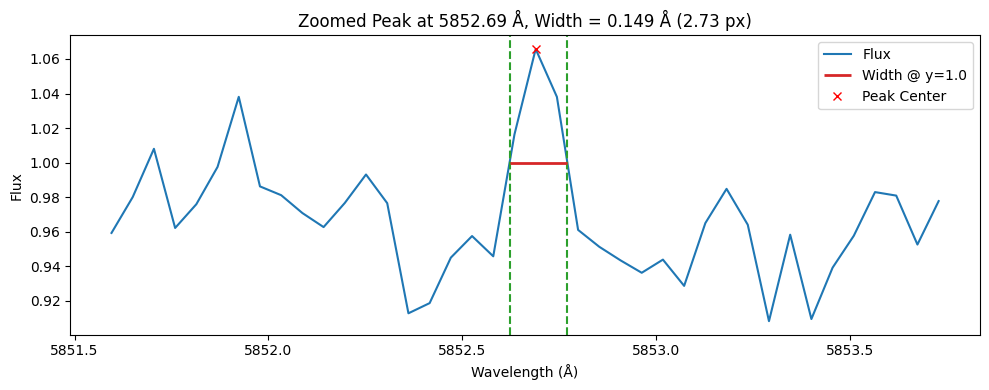

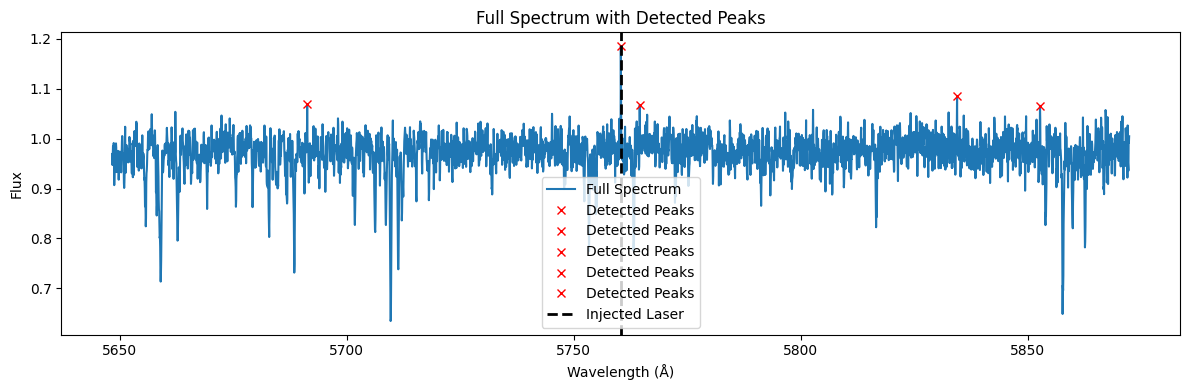

detection func success
Injected at 5760.36 Angstrom Å — RECOVERED ✅
Detected 5 peaks vs 1 injections
Precision: 20.00%
Recall: 100.00%
F1 Score: 33.33%
[np.float64(5691.272657680871), np.float64(5760.357427598454), np.float64(5764.514547561824), np.float64(5834.419801682703), np.float64(5852.689249942777)]


In [33]:
# Loop through all files in the folder
folder = "/datax/scratch/emmay/galah_spectra"
fits_files = [f for f in os.listdir(folder) if f.endswith(".fits")]

# Limit to first 40 objects
for fits_file in fits_files[:10]:
    filename_no_ext = fits_file[:-5]  # Removes ".fits"
    obj_id = filename_no_ext[:15]
    filt = filename_no_ext[16:]  # Skip underscore at index 15
    
    print(f"Processing: {obj_id}_{filt}")
    
    try:
        # Step 1: Inject laser
        wave, flux, injected_wl, wav_injected = inject_and_plot_laser(obj_id, filt, folder=folder, plot=True)
        print("Injected laser success")

        # Step 2: Try to detect it
        detected_wavelengths, _ = detect_laser_peak_with_fixed_level_width(
            wave, flux, height_fraction=0.15, y_level=1.0, max_pixel_width=5, injected_wavelength=wav_injected, plot=True
        )
        print("detection func success")


        # Step 3: Report
        injected_wavelengths = [wav_injected]

        stats, matched = evaluate_detection(
            injected_wavelengths = [wav_injected],

            # Flatten detected peaks if nested
            detected_wavelengths = detected_wavelengths,
            threshold_angstroms=2.0
        )

        for i, was_found in enumerate(matched):
            print(f"Injected at {injected_wavelengths[i]:.2f} Å — {'RECOVERED ✅' if was_found else 'NOT FOUND ❌'}")

        print(f"Detected {stats['n_detected']} peaks vs {stats['n_injected']} injections")
        print(f"Precision: {stats['precision']:.2%}")
        print(f"Recall: {stats['recall']:.2%}")
        print(f"F1 Score: {stats['f1_score']:.2%}")
        print(detected_wavelengths)


    except Exception as e:
        print(f"Error processing {fits_file}: {e}")


- completeness curve (intensity vs fraction recovered)
- wavelength, amplitude of injection plot --> colored injections by whether or not they were recovered
